In [305]:
%matplotlib inline
import PIL as PIL
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d
from scipy.optimize import minimize
plt.rcParams["figure.figsize"] = (12,8)

from numpy import linalg as LA

from scipy.ndimage.filters import gaussian_filter
from skimage import data,exposure,color
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

import time
import os

### 輸入圖片

In [306]:
im = PIL.Image.open('input2.bmp')
im = np.array(im)
im_ori = PIL.Image.open('input2_ori.bmp')
im_ori = np.array(im_ori)
im_sharp = PIL.Image.open('output_test1.bmp')
im_sharp = np.array(im_sharp)

### 定義filter

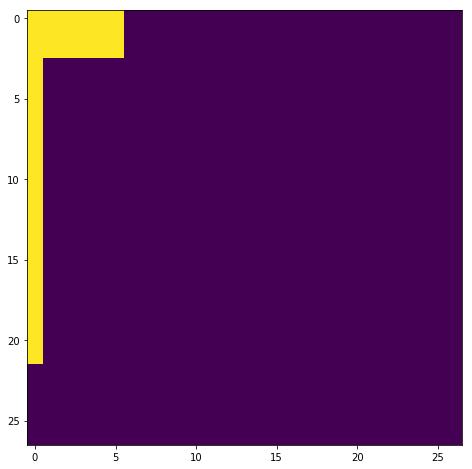

In [307]:
filter_x = np.array([[-1,1]])
filter_xx = np.array([[-1,0,1]])

filter_y = np.array([[-1],[1]])
filter_yy = np.array([[-1],[0],[1]])

filter_xy = np.array([[-1,1],[1,-1]])
filter_f = PIL.Image.open('filter_f_test.bmp').convert('L')
filter_K = np.array(filter_f,dtype=np.float32)
# filter_K = np.load('kernel.npy')
filter_K[filter_K==255] = 1.0
filter_K/=filter_K.sum()

der_filters = [filter_x,filter_y,filter_xx,filter_yy,filter_xy]
filter_K.shape
plt.imshow(filter_K)
plt.show()

### Blur Kernel Estimate

In [308]:
# 參數定義
W = [50.0/2.0,50.0/2.0,50.0/4.0,50.0/4.0,50.0/4.0]
B = 5.0
A = 0.1

### Network Defined

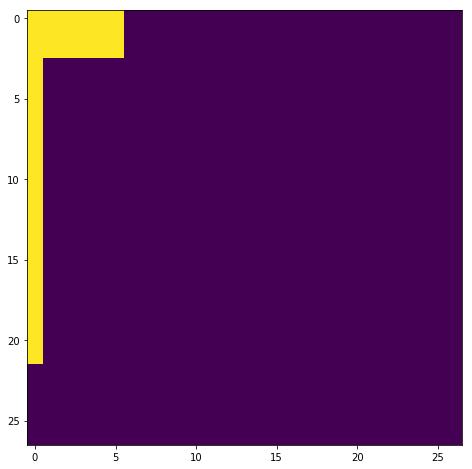

In [323]:
# filter_K = np.load('w_center.npy')
plt.imshow(filter_K)
plt.show()
Tensor_filter_x =  torch.FloatTensor([[-1,1]]).unsqueeze(0).unsqueeze(0)
Tensor_filter_xx = torch.FloatTensor([[-1,0,1]]).unsqueeze(0).unsqueeze(0)
Tensor_filter_y =  torch.FloatTensor([[-1],[1]]).unsqueeze(0).unsqueeze(0)
Tensor_filter_yy = torch.FloatTensor([[-1],[0],[1]]).unsqueeze(0).unsqueeze(0)
Tensor_filter_xy = torch.FloatTensor([[-1,1],[1,-1]]).unsqueeze(0).unsqueeze(0)
Tensor_filter_f = torch.from_numpy(filter_K.astype(np.float32)).unsqueeze(0).unsqueeze(0)
class Blind_Deblur(nn.Module):
    def __init__(self):
        super(Blind_Deblur, self).__init__()
        self.threshold = nn.Hardtanh(-0.5, 0.5)
        
        self.pad = nn.ReplicationPad2d((13, 13, 13, 5))
        self.convf = nn.Conv2d(1, 1, (27,271),(1,1),(0,0),bias=True)
        self.convf.weight.data = Tensor_filter_f

        self.pad_x = nn.ReplicationPad2d((1, 0, 0, 0))
        self.der_x = nn.Conv2d(1, 1, (1,2),(1,1),(0,0),bias=False)
        self.der_x.weight.data = Tensor_filter_x

        self.pad_xx = nn.ReplicationPad2d((1, 0, 0, 0))
        self.der_xx = nn.Conv2d(1, 1, (1,3),(1,1),(0,1),bias=False)
        self.der_xx.weight.data = Tensor_filter_xx
        for params in self.der_xx.parameters():
            params.requires_grad = False
        
        self.pad_y = nn.ReplicationPad2d((0, 0, 1, 0))
        self.der_y = nn.Conv2d(1, 1, (2,1),(1,1),(0,0),bias=False)
        self.der_y.weight.data = Tensor_filter_y

        self.der_yy = nn.Conv2d(1, 1, (3,1),(1,1),(1,0),bias=False)
        self.der_yy.weight.data = Tensor_filter_yy

        self.pad_xy = nn.ReplicationPad2d((1, 0, 1, 0))
        self.der_xy = nn.Conv2d(1, 1, (2,2),(1,1),(0,0),bias=False)
        self.der_xy.weight.data = Tensor_filter_xy

    def forward(self,x,B):
        

        convf = self.convf(self.pad(x))
        
        der_x_L = self.convf(self.pad(self.threshold(self.der_x(self.pad_x(x)))))
#         print(der_x_L.size())
        der_xx_L = self.convf(self.pad(self.threshold(self.der_xx(x))))
#         print(der_xx_L.size())
        der_y_L = self.convf(self.pad(self.threshold(self.der_y(self.pad_y(x)))))
#         print(der_y_L.size())
        der_yy_L = self.convf(self.pad(self.threshold(self.der_yy(x))))
        der_xy_L = self.convf(self.pad(self.threshold(self.der_xy(self.pad_xy(x)))))
#         print(der_yy_L.size(),der_xy_L.size())
        der_x_B = self.der_x(self.pad_x(B))
        der_xx_B = self.der_xx(B)
#         print(der_x_B.size(),der_xx_B.size())
        der_y_B = self.der_y(self.pad_y(B))
        der_yy_B = self.der_yy(B)
#         print(der_y_B.size(),der_yy_B.size())
        der_xy_B = self.der_xy(self.pad_xy(B))
#         print(der_xy_B.size())
        der_laplace_L = self.der_xy(self.pad_xy(x))
#         print(der_laplace_L.size())
#         print(convf.size())
        return (convf-B,der_x_L-der_x_B,der_y_L-der_y_B,der_xx_L-der_xx_B,der_yy_L-der_yy_B,der_xy_L-der_xy_B,der_laplace_L)


### Latent Image Estimation

In [324]:
tensor_transform = transforms.Compose([
transforms.ToTensor(),
])
L_tensor = tensor_transform(im)
L_sharp_tensor = tensor_transform(im_sharp)

L_tensor_R = L_tensor[0].unsqueeze(0)
L_tensor_G = L_tensor[1].unsqueeze(0)
L_tensor_B = L_tensor[2].unsqueeze(0)
L_input = torch.stack([L_tensor_R,L_tensor_G,L_tensor_B])

L_sharp_tensor_R = L_sharp_tensor[0].unsqueeze(0)
L_sharp_tensor_G = L_sharp_tensor[1].unsqueeze(0)
L_sharp_tensor_B = L_sharp_tensor[2].unsqueeze(0)

L_sharp_input = torch.stack([L_sharp_tensor_R,L_sharp_tensor_G,L_sharp_tensor_B])

B_input = L_input.clone()

# model = Blind_Deblur()
def train_model(model,L_init,B, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        
            
        #scheduler.step()
        model.train(True)  # Set model to training mode
        running_loss = 0.0

        # Iterate over data.
        for i in range(1): 
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # 
            c, x0, y0, xx0, yy0, xy0,laplace = model(L_init,B)
            loss =  W[0]*torch.mul(c,c).sum()#+W[1]*torch.mul(x0,x0).sum()+W[1]*torch.mul(y0,y0).sum()+W[2]*torch.mul(xx0,xx0).sum()+W[2]*torch.mul(xy0,xy0).sum()+0.1*torch.mul(laplace,laplace).sum()
#             W[0]*torch.mul(c,c).sum()+W[1]*torch.mul(x0,x0).sum()+W[1]*torch.mul(y0,y0).sum()+W[2]*torch.mul(xx0,xx0).sum()+W[2]*torch.mul(xy0,xy0).sum()+0.1*torch.mul(laplace,laplace).sum()
            
            
            loss.backward()

            optimizer.step()
            L_init.data -= (0.001*L_init.grad.data)
            L_init.grad.data.zero_()
#             statistics
            running_loss += loss.data[0]
        epoch_loss = running_loss 
        print('Loss: {:.4f}'.format(epoch_loss))
#     deep copy the model
    

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    return model,L_init,B


In [326]:
L_init_R = Variable(L_tensor_R,requires_grad=True)
L_init_G = Variable(L_tensor_G,requires_grad=True)
L_init_B = Variable(L_tensor_B,requires_grad=True)
B = Variable(B_input.cuda())
L_init = Variable(L_input.cuda(),requires_grad=True)
L_sharp_init = Variable(L_sharp_input.cuda(),requires_grad=True)
model = Blind_Deblur()
model = model.cuda()
optimizer_ft = optim.Adam(model.convf.parameters(), lr=0.000001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model,L_o,B_o = train_model(model,L_init ,B,optimizer_ft, exp_lr_scheduler, 100)
# for i in range(20):
#     model,L_o,B_o = train_model(model,L_init ,B,optimizer_ft, exp_lr_scheduler, 20)


Epoch 0/99
----------
Loss: 43219.9531
Epoch 1/99
----------
Loss: 38486.7500
Epoch 2/99
----------
Loss: 35305.8047
Epoch 3/99
----------
Loss: 33226.5156
Epoch 4/99
----------
Loss: 33198.1836
Epoch 5/99
----------
Loss: 39468.1719
Epoch 6/99
----------
Loss: 67789.3906
Epoch 7/99
----------
Loss: 175400.8750
Epoch 8/99
----------
Loss: 569657.4375
Epoch 9/99
----------
Loss: 2000872.6250
Epoch 10/99
----------
Loss: 7182901.5000
Epoch 11/99
----------
Loss: 25925976.0000
Epoch 12/99
----------
Loss: 93676416.0000
Epoch 13/99
----------
Loss: 338440384.0000
Epoch 14/99
----------
Loss: 1222270848.0000
Epoch 15/99
----------
Loss: 4412149760.0000
Epoch 16/99
----------
Loss: 15919132672.0000
Epoch 17/99
----------
Loss: 57407909888.0000
Epoch 18/99
----------
Loss: 206920859648.0000
Epoch 19/99
----------
Loss: 745444671488.0000
Epoch 20/99
----------
Loss: 2684120203264.0000
Epoch 21/99
----------
Loss: 9659677147136.0000
Epoch 22/99
----------
Loss: 34745253625856.0000
Epoch 23/99
-

KeyboardInterrupt: 

In [316]:
# L_o.data -= (5.0*L_o.grad.data)
L_o_test = L_init.data - 0.0*L_o.grad.data
# L_o.grad.data

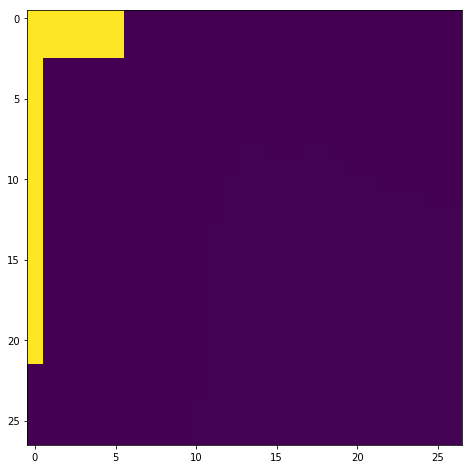

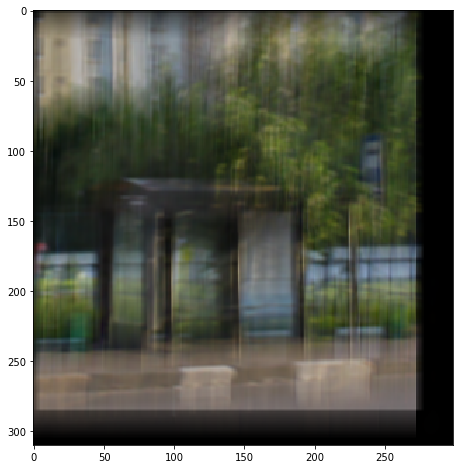

In [317]:
w = model.convf.weight.data.cpu()

w = w.numpy()
# np.save('kernel_1124_1',w)
# PIL.Image.fromarray(w*255.0)
# w_g = gaussian_filter(w[0][0], 1.0)
plt.imshow(w[0][0])
plt.show()

reconvolution_R = convolve2d(im_ori[:,:,0]/255.0,w[0][0])
reconvolution_G = convolve2d(im_ori[:,:,1]/255.0,w[0][0])
reconvolution_B = convolve2d(im_ori[:,:,2]/255.0,w[0][0])
temp = np.dstack([reconvolution_R,reconvolution_G,reconvolution_B])
temp[temp>1] = 1.0
temp[temp<0] = 0.0
plt.imshow(temp)
plt.show()


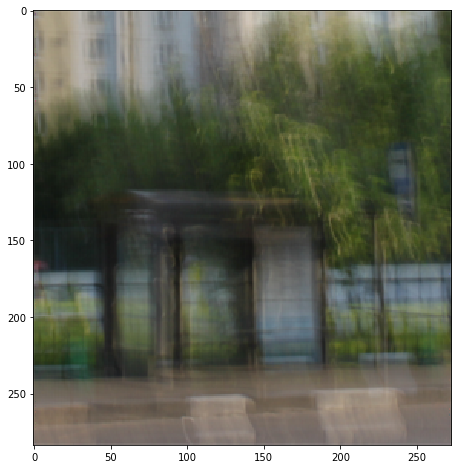

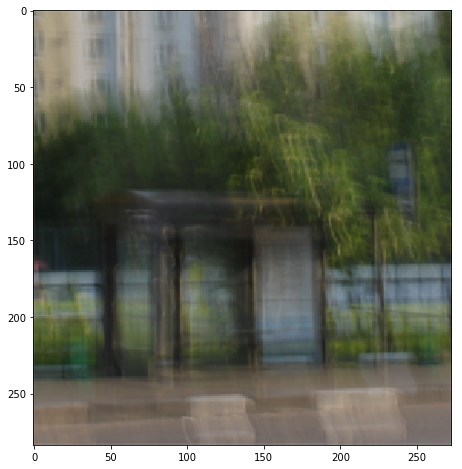

58.7099436515
58.7039272589


58.703927258931287

In [277]:
L_cpu = L_o_test.cpu()
out_im = np.dstack([L_cpu[0][0].numpy(),L_cpu[1][0].numpy(),L_cpu[2][0].numpy()])
out_im[out_im>1] = 1.0
out_im[out_im<0] = 0.0
plt.imshow(out_im)
plt.show()
plt.imshow(im)
plt.show()

def psnr(im1,im2):
    psnr = 0.0
    
    for i in range(3):
        diff = np.abs(im1[:,:,i] - im2[:,:,i])
        rmse = np.square(diff).sum()/(im2.shape[0]*im2.shape[1])
        psnr += 10*np.log10(255.0*255.0/rmse)
    print(psnr)
    return psnr

psnr((out_im*255.0).astype(np.float64),im_ori.astype(np.float64))
psnr(im.astype(np.float64),im_ori.astype(np.float64))

In [278]:
#直方圖平衡後，做兩次log轉換提升暗處亮度
im_hsv = color.rgb2hsv((out_im*255.0).astype(np.uint8))
med_eq = im_hsv.copy()
 

# med_eq[:,:,2] = exposure.equalize_adapthist(med_eq[:,:,2],21)
# med_eq[:,:,2] = np.log2(1.0+med_eq[:,:,2])
# med_eq[:,:,2] = np.log2(1.0+med_eq[:,:,2])

# med_eq[:,:,2]*=0.97



med_eq_rgb = (color.hsv2rgb(med_eq)*255).astype(np.uint8)
psnr(med_eq_rgb,im_ori)
psnr(im,im_ori)
output = PIL.Image.fromarray(med_eq_rgb)
output.save('output_test3.bmp')


86.364782055
86.3197725092
